# Prepare Env

In [2]:
# Library

import platform
import sys
import os

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler
import torchvision
from glob import glob
import cv2

from scipy.stats import multivariate_normal

from PIL import Image

from tqdm import tqdm

# import albumentations as A
from sklearn.model_selection import train_test_split
# import segmentation_models_pytorch as smp

In [3]:
# Find session type
def find_session_type():
    # windows
    if os.name == 'nt':
        path = '../input/data/'

        import japanize_matplotlib
        sns.set(font="IPAexGothic")

    elif platform.system()  == 'Darwin':
        # Mac
        path = '../input/data/'
        return 'mac'

    elif os.name == 'posix':
    # Kaggle
        if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
            print('This is kaggle session')
            return 'kaggle'

    # Google Colab
        else:
            print('This is colab session')
            # セッションの残り時間の確認
            !cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 / 60 / 60 "h)"}'
            return 'colab'
    # Mac
    # elif 'MAC' in os.environ.keys():
    #     print('This is mac session')
    #     return 'mac'
# Example usage:
if find_session_type() == 'kaggle':
    print("Running in a Kaggle notebook")
elif find_session_type() == 'mac':
    print("Running on a Mac")
    path = '../input/data/'

elif find_session_type() == 'colab':
    from google.colab import drive
    print("Running in Google Colab")
    drive.mount('/content/drive')
    os.makedirs('/content/logs', exist_ok=True)
    os.makedirs('/content/kaggle/input', exist_ok=True)
    os.makedirs('/content/kaggle/output', exist_ok=True)
else:
    print("Not running in a Kaggle notebook or Google Colab")

# if is_google_colab():
#   byu_locating_bacterial_flagellar_motors_2025_path = kagglehub.competition_download('byu-locating-bacterial-flagellar-motors-2025')

#   print('Data source import complete.')

class Config:
    def __init__(self):
        self.seed = 42
        self.debug = False
        self.epochs = 10
        self.num_classes = 86
        self.ramdom_seed = 42
        self.batch_size = 4
        self.no_motor_use = 10

        self.train_size = 0.8
        self.voxel_size = 256
        # Torch settings
        self.translate = 0.5
        self.lr = 1e-4
        self.grad_norm = 0.1
        self.init_scale = 4096

        self.root_dir = ''
        if find_session_type() == 'kaggle':
            self.root_dir = '/kaggle/'
        elif find_session_type() == 'colab':
            self.root_dir = '/content/kaggle/'
        elif find_session_type() == 'mac':
            self.root_dir = '../'
        self.working_dir = os.path.join(self.root_dir, 'working')
        self.data_dir = os.path.join(self.root_dir, 'input', 'byu-locating-bacterial-flagellar-motors-2025')
        self.output_dir = os.path.join(self.root_dir, 'output')
        self.dataset_dir = os.path.join(self.working_dir, 'dataset')
        self.train_image_dir = os.path.join(self.dataset_dir, 'images','train')
        self.train_label_dir = os.path.join(self.dataset_dir, 'labels','train')
        self.val_image_dir = os.path.join(self.dataset_dir, 'images','val')
        self.val_label_dir = os.path.join(self.dataset_dir, 'labels','val')

        os.makedirs(self.dataset_dir, exist_ok=True)
        os.makedirs(self.train_image_dir, exist_ok=True)
        os.makedirs(self.train_label_dir, exist_ok=True)
        os.makedirs(self.val_image_dir, exist_ok=True)
        os.makedirs(self.val_label_dir, exist_ok=True)

        assert os.path.exists(self.data_dir), f"Data directory {self.data_dir} does not exist."

        random.seed(self.ramdom_seed)
        np.random.seed(self.ramdom_seed)
        torch.manual_seed(self.ramdom_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(self.ramdom_seed)
            torch.backends.cudnn.deterministic = True

class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None

    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        # print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True

    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")

    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU

config = Config()

config.batch_size = BATCH_SIZE

Running on a Mac
GPU not available, using CPU


# Helper Setup

For create dataset, train, and predict

In [4]:
def make_crop_gaussian_box(
    motor_centers:pd.DataFrame,
    volume_shape=(256, 256, 256),
    crop_origin=(0, 0, 0),
    cov = [[0.1,0,0],[0,0.1,0],[0,0,0.1]],
    shapness_factor=2
):
    """
    Calculate Gaussian distribution function for a given motor center

    Args:
        motor_centers(pd.DataFrame): Each motor center coordinates
        volume_shape()
    """

    dz, dy, dx = volume_shape
    z0, y0, x0 = crop_origin
    # create 3d mesh
    z = np.linspace(0, 1, dz)
    y = np.linspace(0, 1, dy)
    x = np.linspace(0, 1, dx)
    z, y, x = np.meshgrid(z, y, x)

    pdf = np.zeros((dz, dy, dx))
    if motor_centers.iloc[0,0] == -1:
        pdf = np.zeros((dz, dy, dx))
        return pdf
    for row in motor_centers.iterrows():
        motor_cen = row[1].values
        motor_cen = [(motor_cen[0]-z0)/dz, (motor_cen[1]-y0)/dy, (motor_cen[2]-x0)/dx]
        rv = multivariate_normal(mean=motor_cen, cov=cov)
        pdf += rv.pdf(np.stack((z, y, x), axis=-1))
    
    pdf = pdf ** shapness_factor
    pdf = np.clip(pdf, 0, 1)
    return torch.tensor(pdf, dtype=torch.float32).to(device)

def image_processor(image_path:os.PathLike, start_y:int, start_x:int)->np.ndarray:
    """
    Open image, convert to grayscale, normalize, and crop

    Args:
        image_path(os.PathLike): Path to the image
        start_x:int, start_y:int): Index of the crop starting
    """
    _img = cv2.imread(image_path)
    _gamma22LUT = np.array([((i / 255) ** (1 / 2.2)) * 255 for i in range(256)]).astype(np.uint8)
    _img = cv2.LUT(_img, _gamma22LUT)
    _img = cv2.normalize(_img, None, 0, 255, cv2.NORM_MINMAX)
    _img_gray = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
    _img_gray = cv2.normalize(_img_gray, None, 0, 255, cv2.NORM_MINMAX)
    _array = _img_gray[start_y:start_y+config.voxel_size, start_x:start_x+config.voxel_size]
    return _array

def crop_pos_set(z_max:int, y_max:int, x_max:int, start_z:int, start_y:int, start_x:int):
    """
    z_max, y_max, x_max: 全体画像のサイズ
    start_z, start_y, start_x: cropの開始位置
    """
    if start_z < 0:
        start_z = 0
    elif start_z > z_max - config.voxel_size:
        start_z = z_max - config.voxel_size
    if start_y < 0:
        start_y = 0
    elif start_y > y_max - config.voxel_size:
        start_y = y_max - config.voxel_size
    if start_x < 0:
        start_x = 0
    elif start_x > x_max - config.voxel_size:
        start_x = x_max - config.voxel_size

    return (start_z, start_y, start_x)

def crop_and_extract_slices(tomo_id:str, cov:np.ndarray, train_df:pd.DataFrame, start_z, start_y, start_x):
    """
    Crop and extract voxel tensor from the slices

    Args:
        cov(np.ndarray): Covariance matrix
        tomo_id(str): Tomo ID
        start_z(int): Crop start z index
        start_y(int): Crop start y index
        start_x(int): Crop start x index
    """
    z_max = train_df[train_df['tomo_id'] == tomo_id].loc[:,'Array shape (axis 0)'].max()
    y_max = train_df[train_df['tomo_id'] == tomo_id].loc[:,'Array shape (axis 1)'].max()
    x_max = train_df[train_df['tomo_id'] == tomo_id].loc[:,'Array shape (axis 2)'].max()
    _motor_centers = train_df[train_df['tomo_id'] == tomo_id].loc[:,['Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    _crop_origin = (start_z, start_y, start_x)

    label_tensor = make_crop_gaussian_box(
    volume_shape=(config.voxel_size, config.voxel_size, config.voxel_size),
    crop_origin=_crop_origin,
    motor_centers=_motor_centers,
    cov=cov
    )

    slice_array = None
    _slice_arrays = []

    start_z, start_y, start_x = crop_pos_set(z_max, y_max, x_max, start_z, start_y, start_x)

    for slice in range(start_z, start_z+config.voxel_size):
        tomo_path = os.path.join(config.data_dir, 'train', tomo_id, f"slice_{slice:04d}.jpg")
        if not os.path.exists(tomo_path):
            print(f"Missing slice_{slice:04d} for {tomo_id}")
        slice_array = image_processor(tomo_path, start_y, start_x)
        if slice_array.shape[0] != config.voxel_size:
            print(f"Slice {slice} shape is {slice_array.shape}")
        _slice_arrays.append(slice_array)

    voxel_tensor = np.stack(_slice_arrays, axis=0)
    # Grayscale
    voxel_tensor = torch.tensor(voxel_tensor, dtype=torch.float16, device=device)
    del slice_array, _motor_centers, _crop_origin, _slice_arrays
    return label_tensor,voxel_tensor

3D-CNNに読み込ませる


In [ ]:
# Model developing

# 3D U-net by pytorch

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_ch, mdl_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding="same"),
            nn.BatchNorm3d(mdl_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(mdl_ch, out_ch, kernel_size=3, padding="same"),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
class UpConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="trilinear", align_corners=True)
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(1, 8, 8)
        self.enc2 = DoubleConv(8, 32, 32)
        self.enc3 = DoubleConv(32, 128, 128)
        self.enc4 = DoubleConv(128, 512, 512)

        self.bottleneck = DoubleConv(512, 1024, 1024)

        self.up4 = UpConv_3D(1024, 512)
        self.dec4 = DoubleConv(512, 512, 512)
        self.up3 = UpConv_3D(512, 128)
        self.dec3 = DoubleConv(256, 128, 128)
        self.up2 = UpConv_3D(128, 32)
        self.dec2 = DoubleConv(128, 32, 32)
        self.up1 = UpConv_3D(32, 8)
        self.dec1 = DoubleConv(16, 8, 8)

        self.conv1 = nn.Conv3d(8, 1, kernel_size=1)

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.enc1(x)
        x1 = x
        x = self.pool(x)

        x = self.enc2(x)
        x2 = x
        x = self.pool(x)

        x = self.enc3(x)
        x3 = x
        x = self.pool(x)

        x = self.enc4(x)
        x4 = x
        x = self.pool(x)

        x = self.bottleneck(x)

        x = self.up4(x)
        x = torch.cat((x, x4), dim=1)
        x = self.dec4(x)

        x = self.up3(x)
        x = torch.cat((x, x3), dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat((x, x2), dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat((x, x1), dim=1)
        x = self.dec1(x)

        x = self.conv1(x)
        return x

def check_dataset_consistency(dataset_or_loader, num_samples=5, visualize=True):
    """
    3D-UNet用データセットまたはデータローダーのバリデーションを行う関数。

    Args:
        dataset_or_loader: PyTorch DatasetまたはDataLoaderインスタンス
        num_samples: チェックするサンプル数
        visualize: Trueなら入力・ラベルを可視化する
    """
    print("\n=== Dataset Consistency Check Start ===\n")

    if hasattr(dataset_or_loader, 'dataset'):
        # DataLoaderの場合
        dataset = dataset_or_loader.dataset
        loader = dataset_or_loader
        use_loader = True
    else:
        # Datasetの場合
        dataset = dataset_or_loader
        use_loader = False

    if use_loader:
        data_iter = iter(loader)
    else:
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for i in range(num_samples):
        if use_loader:
            batch = next(data_iter)
            X, Y = batch
            X, Y = X[0], Y[0]  # バッチの最初のサンプルを使用
        else:
            idx = indices[i]
            X, Y = dataset[idx]

        # --- 1. 形状チェック ---
        assert X.ndim == 4, f"Input X should have 4 dimensions (C,D,H,W), got {X.shape}"
        assert Y.ndim == 3 or Y.ndim == 4, f"Label Y should have 3 or 4 dimensions, got {Y.shape}"

        # --- 2. チャンネル数確認 ---
        C, D, H, W = X.shape
        assert C in [1, 3], f"Unexpected channel count {C}"

        # --- 3. 値の範囲確認 ---
        if torch.is_tensor(X):
            X_min, X_max = X.min().item(), X.max().item()
        else:
            X_min, X_max = np.min(X), np.max(X)

        print(f"Sample {i}: Input value range = ({X_min:.3f}, {X_max:.3f})")
        assert not np.isnan(X_min) and not np.isnan(X_max), "NaN detected in input"

        # --- 4. 型確認 ---
        assert isinstance(X, (torch.Tensor, np.ndarray)), "Input X must be Tensor or ndarray"
        assert isinstance(Y, (torch.Tensor, np.ndarray)), "Label Y must be Tensor or ndarray"

        # --- 5. 欠損値チェック ---
        if torch.isnan(X).any() or torch.isnan(Y).any():
            raise ValueError(f"NaN found in sample {i}")

        # --- 6. 入力とラベルの対応確認 ---
        if Y.ndim == 4:
            assert Y.shape[1:] == X.shape[1:], f"Mismatch between input and label shape: {X.shape} vs {Y.shape}"
        else:
            assert Y.shape == X.shape[1:], f"Mismatch between input and label shape: {X.shape} vs {Y.shape}"

        # --- 7. 簡易可視化 ---
        if visualize:
            slice_idx = D // 2
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))

            axs[0].imshow(X[0, slice_idx].cpu().numpy(), cmap='gray')
            axs[0].set_title('Input (Mid slice)')

            if Y.ndim == 4:
                axs[1].imshow(Y[0, slice_idx].cpu().numpy(), cmap='gray')
            else:
                axs[1].imshow(Y[slice_idx].cpu().numpy(), cmap='gray')
            axs[1].set_title('Label (Mid slice)')

            plt.show()

    print("\n=== Dataset Consistency Check Completed ===\n")
# Check the model network
model = UNet3D().to(device)
print(model)

# Loss function
def criterion(pred, target):
    """
    Custom loss function for 3D U-Net model.
    Args:
        pred (torch.Tensor): Predicted output from the model.
        target (torch.Tensor): Ground truth labels.
    Returns:
        torch.Tensor: Computed loss value.
    """
    loss_fn = nn.SmoothL1Loss(reduction='mean')
    # Calculate the loss using the defined loss function
    loss = loss_fn(pred, target)
    return loss

def predict_on_samples(model:torch.nn.Module, dataloader:DataLoader, num_samples:int=5, thresh:float=0.7):
    
    """
    Predict on a few samples from the dataloader and visualize the results.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        num_samples (int): Number of samples to visualize.
        thresh (float): Threshold for binarizing the predictions.
    """
    model.eval()
    fig, axs = plt.subplots(3, num_samples, figsize=(12, 4))
    with torch.no_grad():
        for i, (X, Y) in tqdm(enumerate(dataloader)):
            if i >= num_samples:
                break
            X = X.to(device)
            Y = Y.to(device)

            pred = model(X)
            pred = torch.sigmoid(pred)

            # Visualize the first sample
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            slice_idx = X.shape[2] // 2

            axs[i,0].imshow(X[0, 0, slice_idx].cpu().numpy(), cmap='gray')
            axs[i,0].set_title('Input')

            axs[i,1].imshow(Y[0, slice_idx].cpu().numpy(), cmap='hot')
            axs[i,1].set_title('Ground Truth')

            axs[i,2].imshow(pred[0, 0, slice_idx].cpu().numpy(), cmap='hot')
            axs[i,2].set_title('Prediction')

        fig.show()

class CustomDataset(torch.utils.data.TensorDataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = glob(os.path.join(image_dir, '*.pt'))
        self.label_files = glob(os.path.join(label_dir, '*.pt'))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label_path = self.label_files[idx]

        image_tensor = torch.load(image_path).unsqueeze(0)  # Add channel dimension
        label_tensor = torch.load(label_path)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label_tensor

def simple_3d_nms(pred, threshold=0.5, kernel_size=3):
    """
    Simple 3D Non-Maximum Suppression (NMS) function.
    Args:
        pred (torch.Tensor): Input tensor of shape (C, D, H, W).
        threshold (float): Threshold for NMS.
        kernel_size (int): Size of the kernel for NMS.
    Returns:
        torch.Tensor: Output tensor after applying NMS.
    """

    if pred.ndim == 4:
        pred = pred.squeeze(0)
    if pred.ndim != 4:
        raise ValueError("Input tensor must have 4 dimensions (C, D, H, W)")
    pred = F.threshold(pred, threshold, 0)
    pooled = F.max_pool3d(pred.unsqueeze(0).unsqueeze(0),
                          kernel_size=kernel_size, stride=1,
                          padding=kernel_size//2)

    peaks = (pred == pooled) & (pooled > threshold)
    peak_coords = torch.nonzero(peaks, as_tuple=False)
    return peak_coords.cpu().numpy()

UNet3D(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(
      (0): C

### Train Section

Train dataset size: 1

=== Dataset Consistency Check Start ===

Sample 0: Input value range = (0.000, 255.000)


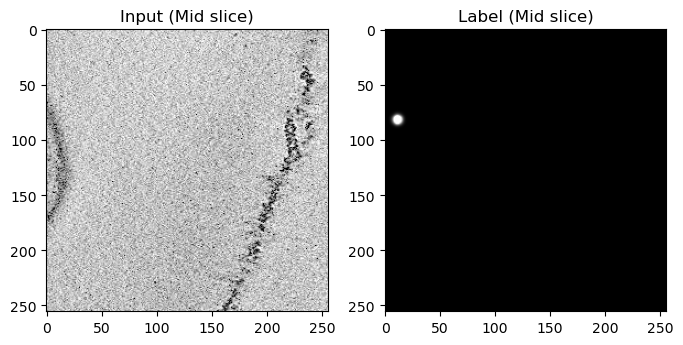

/Users/teramoto/.pyenv/versions/miniforge3-23.11.0-0/envs/byu/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



=== Dataset Consistency Check Completed ===



  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
history = {
    'train_loss': [],
    'val_loss': []
}
model = UNet3D()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

train_dataset = CustomDataset(config.train_image_dir, config.train_label_dir)
val_dataset = CustomDataset(config.val_image_dir, config.val_label_dir)

print(f"Train dataset size: {len(train_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# Validation
check_dataset_consistency(train_loader, num_samples=1, visualize=True)

scaler = GradScaler(init_scale=config.init_scale)

for epoch in tqdm(range(config.epochs)):
    train_loss = 0.0
    val_loss = 0.0

    for x, y in tqdm(train_loader):
        optimizer.zero_grad()

        with autocast(device, dtype=torch.float16):
            y = model(x)
            loss = criterion(x, y)

        scaler.scale(loss).backward()
        loss.backward()
        scaler.unscale_(optimizer)

        nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        history['train_loss'].append(loss.item())
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for val_x, val_y in tqdm(val_loader):
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_y = model(val_x)
            loss = criterion(val_x, val_y)
            val_loss += loss

    val_loss /= len(val_loader)
    history['val_loss'].append(loss.item())
    print(f"Epoch [{epoch+1}/{config.epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

predict_on_samples(model, val_loader, num_samples=5)